<span style='background:#DCEDC8; font-size:30px; display:block; border-left:40px solid #C5E1A5; padding-left:40px;'>
<b>
    Download multiple meteoscreening variables
</b>
</span>

- This notebook was used to download diive meteoscreened data for 2024.
- 2023 was also downloaded so it can be used to gap-fill 2024 data.
- Data downloaded here were only used for final flux calculations (Level-1) for 2024.
- Data for 2024 was added to the already existing data file with the 6 meteo variables for EddyPro.

**notebook version**: `3` (4 Jul 2024)  
**new in this version**: added check if downloaded data is indeed in 30MIN time resolution

- This notebook can be used to download data from the database `InfluxDB`
- Data are stored to a `.csv` file in this folder

</br>

# **Auto-settings**

## Data settings

In [1]:
DIRCONF = r'L:\Sync\luhk_work\20 - CODING\22 - POET\configs'
# DIRCONF = r'P:\Flux\RDS_calculations\_scripts\_configs\configs'  # Folder with configuration files: needed e.g. for connection to database
TIMEZONE_OFFSET_TO_UTC_HOURS = 1  # Timezone, e.g. "1" is translated to timezone "UTC+01:00" (CET, winter time)
REQUIRED_TIME_RESOLUTION = '30min'  # 30MIN time resolution

## Imports

In [2]:
from datetime import datetime
import importlib.metadata
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme('notebook')
from diive.core.plotting.timeseries import TimeSeries
from dbc_influxdb import dbcInflux
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.core.times.times import DetectFrequency
from diive.core.times.times import TimestampSanitizer
from diive.pkgs.createvar.potentialradiation import potrad
from diive.pkgs.gapfilling.xgboost_ts import XGBoostTS
import warnings
from influxdb_client.client.warnings import MissingPivotFunction
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")
version_dbc = importlib.metadata.version("dbc_influxdb")
print(f"dbc-influxdb version: v{version_dbc}")
dbc = dbcInflux(dirconf=DIRCONF)  # Connect to database

diive version: v0.85.0
dbc-influxdb version: v0.12.0
Reading configuration files was successful.
Connection to database works.


</br>

# **Download**

In [3]:
OUTFILE = f"12.3_meteo6_2023-2024_forEddyPro2024.csv"

## Download meteo data from diive meteoscreening (2023-2024)

In [4]:
%%time
data_simple, data_detailed, assigned_measurements = dbc.download(
    bucket=f'ch-cha_processed',
    measurements=['TA', 'RH', 'LW', 'PPFD', 'SW', 'PA'],
    fields=['TA_T1_2_1', 'RH_T1_2_1', 'LW_IN_T1_2_1', 'PPFD_IN_T1_2_2', 'SW_IN_T1_2_1', 'PA_GF1_0.9_1'],
    start='2023-01-01 00:00:01',  # Download data starting with this date (the start date itself IS included),
    stop='2025-01-01 00:00:01',  # Download data before this date (the stop date itself IS NOT included),
    timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
    data_version='meteoscreening_diive'
)


DOWNLOADING
    from bucket ch-cha_processed
    variables ['TA_T1_2_1', 'RH_T1_2_1', 'LW_IN_T1_2_1', 'PPFD_IN_T1_2_2', 'SW_IN_T1_2_1', 'PA_GF1_0.9_1']
    from measurements ['TA', 'RH', 'LW', 'PPFD', 'SW', 'PA']
    from data version meteoscreening_diive
    between 2023-01-01 00:00:01 and 2025-01-01 00:00:01
    with timezone offset to UTC of 1
Used querystring: from(bucket: "ch-cha_processed") |> range(start: 2023-01-01T00:00:01+01:00, stop: 2025-01-01T00:00:01+01:00) |> filter(fn: (r) => r["_measurement"] == "TA" or r["_measurement"] == "RH" or r["_measurement"] == "LW" or r["_measurement"] == "PPFD" or r["_measurement"] == "SW" or r["_measurement"] == "PA") |> filter(fn: (r) => r["data_version"] == "meteoscreening_diive") |> filter(fn: (r) => r["_field"] == "TA_T1_2_1" or r["_field"] == "RH_T1_2_1" or r["_field"] == "LW_IN_T1_2_1" or r["_field"] == "PPFD_IN_T1_2_2" or r["_field"] == "SW_IN_T1_2_1" or r["_field"] == "PA_GF1_0.9_1") |> pivot(rowKey:["_time"], columnKey: ["_field"],

In [5]:
data_simple

,LW_IN_T1_2_1,PA_GF1_0.9_1,PPFD_IN_T1_2_2,RH_T1_2_1,SW_IN_T1_2_1,TA_T1_2_1
TIMESTAMP_END,,,,,,
2023-01-01 00:30:00,281.242257,975.623947,0.0,99.902748,0.0,2.898533
2023-01-01 01:00:00,284.605240,975.725263,0.0,99.902748,0.0,2.994261
2023-01-01 01:30:00,290.366950,975.961540,0.0,99.902748,0.0,3.722800
2023-01-01 02:00:00,299.299250,975.941817,0.0,99.902748,0.0,4.535267
2023-01-01 02:30:00,294.512940,975.794680,0.0,99.902748,0.0,3.949122
...,...,...,...,...,...,...
2024-12-31 22:00:00,304.613900,983.370890,0.0,99.997990,0.0,-1.919472
2024-12-31 22:30:00,303.039890,983.052160,0.0,99.997990,0.0,-2.104678
2024-12-31 23:00:00,302.093633,982.851140,0.0,99.997990,0.0,-2.089444


</br>

# **Adjust units** (if needed)

In [6]:
# Units for PA from meteoscreening_diive are given in mbar (hPa), but are needed in kPa
data_simple['PA_GF1_0.9_1'] = data_simple['PA_GF1_0.9_1'].divide(10)
data_simple

,LW_IN_T1_2_1,PA_GF1_0.9_1,PPFD_IN_T1_2_2,RH_T1_2_1,SW_IN_T1_2_1,TA_T1_2_1
TIMESTAMP_END,,,,,,
2023-01-01 00:30:00,281.242257,97.562395,0.0,99.902748,0.0,2.898533
2023-01-01 01:00:00,284.605240,97.572526,0.0,99.902748,0.0,2.994261
2023-01-01 01:30:00,290.366950,97.596154,0.0,99.902748,0.0,3.722800
2023-01-01 02:00:00,299.299250,97.594182,0.0,99.902748,0.0,4.535267
2023-01-01 02:30:00,294.512940,97.579468,0.0,99.902748,0.0,3.949122
...,...,...,...,...,...,...
2024-12-31 22:00:00,304.613900,98.337089,0.0,99.997990,0.0,-1.919472
2024-12-31 22:30:00,303.039890,98.305216,0.0,99.997990,0.0,-2.104678
2024-12-31 23:00:00,302.093633,98.285114,0.0,99.997990,0.0,-2.089444


</br>

# **Rename variables for merging and for use in EddyPro**

In [7]:
renaming_dict = {
    'LW_IN_T1_2_1': 'Lwin_1_1_1',
    'PPFD_IN_T1_2_2': 'PPFD_1_1_1',
    'RH_T1_2_1': 'RH_1_1_1',
    'SW_IN_T1_2_1': 'Rg_1_1_1',
    'TA_T1_2_1': 'Ta_1_1_1',
    'PA_GF1_0.9_1': 'Pa_1_1_1'
}
data_simple = data_simple.rename(columns=renaming_dict)
data_simple

,Lwin_1_1_1,Pa_1_1_1,PPFD_1_1_1,RH_1_1_1,Rg_1_1_1,Ta_1_1_1
TIMESTAMP_END,,,,,,
2023-01-01 00:30:00,281.242257,97.562395,0.0,99.902748,0.0,2.898533
2023-01-01 01:00:00,284.605240,97.572526,0.0,99.902748,0.0,2.994261
2023-01-01 01:30:00,290.366950,97.596154,0.0,99.902748,0.0,3.722800
2023-01-01 02:00:00,299.299250,97.594182,0.0,99.902748,0.0,4.535267
2023-01-01 02:30:00,294.512940,97.579468,0.0,99.902748,0.0,3.949122
...,...,...,...,...,...,...
2024-12-31 22:00:00,304.613900,98.337089,0.0,99.997990,0.0,-1.919472
2024-12-31 22:30:00,303.039890,98.305216,0.0,99.997990,0.0,-2.104678
2024-12-31 23:00:00,302.093633,98.285114,0.0,99.997990,0.0,-2.089444


</br>

# **Merge data**

In [8]:
data_simple_merged = data_simple.copy()
data_simple_merged
# # Merge data on index
# data_simple_merged = pd.concat([data_simple_fluxnet, data_simple], axis=0)
# data_simple_merged

,Lwin_1_1_1,Pa_1_1_1,PPFD_1_1_1,RH_1_1_1,Rg_1_1_1,Ta_1_1_1
TIMESTAMP_END,,,,,,
2023-01-01 00:30:00,281.242257,97.562395,0.0,99.902748,0.0,2.898533
2023-01-01 01:00:00,284.605240,97.572526,0.0,99.902748,0.0,2.994261
2023-01-01 01:30:00,290.366950,97.596154,0.0,99.902748,0.0,3.722800
2023-01-01 02:00:00,299.299250,97.594182,0.0,99.902748,0.0,4.535267
2023-01-01 02:30:00,294.512940,97.579468,0.0,99.902748,0.0,3.949122
...,...,...,...,...,...,...
2024-12-31 22:00:00,304.613900,98.337089,0.0,99.997990,0.0,-1.919472
2024-12-31 22:30:00,303.039890,98.305216,0.0,99.997990,0.0,-2.104678
2024-12-31 23:00:00,302.093633,98.285114,0.0,99.997990,0.0,-2.089444


</br>

# **Sanitize timestamp**

In [9]:
data_simple_merged = TimestampSanitizer(data=data_simple_merged, output_middle_timestamp=False).get()
data_simple_merged

,Lwin_1_1_1,Pa_1_1_1,PPFD_1_1_1,RH_1_1_1,Rg_1_1_1,Ta_1_1_1
TIMESTAMP_END,,,,,,
2023-01-01 00:30:00,281.242257,97.562395,0.0,99.902748,0.0,2.898533
2023-01-01 01:00:00,284.605240,97.572526,0.0,99.902748,0.0,2.994261
2023-01-01 01:30:00,290.366950,97.596154,0.0,99.902748,0.0,3.722800
2023-01-01 02:00:00,299.299250,97.594182,0.0,99.902748,0.0,4.535267
2023-01-01 02:30:00,294.512940,97.579468,0.0,99.902748,0.0,3.949122
...,...,...,...,...,...,...
2024-12-31 22:00:00,304.613900,98.337089,0.0,99.997990,0.0,-1.919472
2024-12-31 22:30:00,303.039890,98.305216,0.0,99.997990,0.0,-2.104678
2024-12-31 23:00:00,302.093633,98.285114,0.0,99.997990,0.0,-2.089444


</br>

# **Gap-filling**

## Rg

In [10]:
_df = pd.DataFrame()
_df['Rg_1_1_1'] = data_simple_merged[['Rg_1_1_1']].copy()
_df['SW_IN_POT'] = potrad(timestamp_index=_df.index,
                          lat=47.210227,  # CH-CHA
                          lon=8.410645,  # CH-CHA
                          utc_offset=1)
_df

,Rg_1_1_1,SW_IN_POT
TIMESTAMP_END,,
2023-01-01 00:30:00,0.0,0.0
2023-01-01 01:00:00,0.0,0.0
2023-01-01 01:30:00,0.0,0.0
2023-01-01 02:00:00,0.0,0.0
2023-01-01 02:30:00,0.0,0.0
...,...,...
2024-12-31 22:00:00,0.0,0.0
2024-12-31 22:30:00,0.0,0.0
2024-12-31 23:00:00,0.0,0.0


In [11]:
xgb = XGBoostTS(
    input_df=_df,
    target_col='Rg_1_1_1',
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=200,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 35088.


In [12]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()


Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2023-01-01 01:00:00 and 2025-01-01 00:00:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:177.13626	validation_1-rmse:178.11201
[1]	validation_0-rmse:145.30359	validation_1-rmse:146.32329
[2]	validation_0-rmse:125.77732	validation_1-rmse:126.72246
[3]	validation_0-rmse:114.38858	validation_1-rmse:115.31476
[4]	validation_0-rmse:107.53272	validation_1-rmse:108.72557
[5]	validation_0-rmse:103.45596	validation_1-rmse:104.81905
[6]	validation_0-rmse:100.96496	validation_1-rmse:102.82553
[7]	validation_0-rmse:98.60956	validation_1-rmse:100.67394
[8]	validation_0-rmse:96.86679	validation_1-rmse:99.35304
[9]	validation_0-rmse:95.92622	validation_1-rmse:98.35885
[10]	validation_0-rmse:95.03533	validation_1-rmse:97.72966
[11]	validation_0-rmse:93.72795	validation_1-rmse:96.56942
[12]	validation_0-rmse:91.88373	validation_1-rmse:95.17782
[13]	validation_0-rmse:90.91926	val

In [13]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()


Gap-filling using final model ...
>>> Using final model on all data to predict target Rg_1_1_1 ...
>>> Using final model on all data to calculate permutation importance ...
>>> Calculating prediction scores based on all data predicting Rg_1_1_1 ...
>>> Predicting target Rg_1_1_1 where all features are available ... predicted 35088 records.
>>> Collecting results for final model ...
>>> Filling 13 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable Rg_1_1_1_gfXG ...
>>> Restoring original timestamp in results ...
>>> Combining predictions from full model and fallback model ...

GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (13 values, Rg_1_1_1_gfXG where flag=1) in comparison to observed targets (35075 values, Rg_1_1_1).

## TARGET
- first timestamp:  2023-01-01 00:30:00
- last timestamp:  2025-01-01 00:00:00
- potential number of values: 35088 values)
- target col

In [14]:
observed = _df['Rg_1_1_1']
gapfilled = xgb.get_gapfilled_target()
data_simple_merged[gapfilled.name] = gapfilled

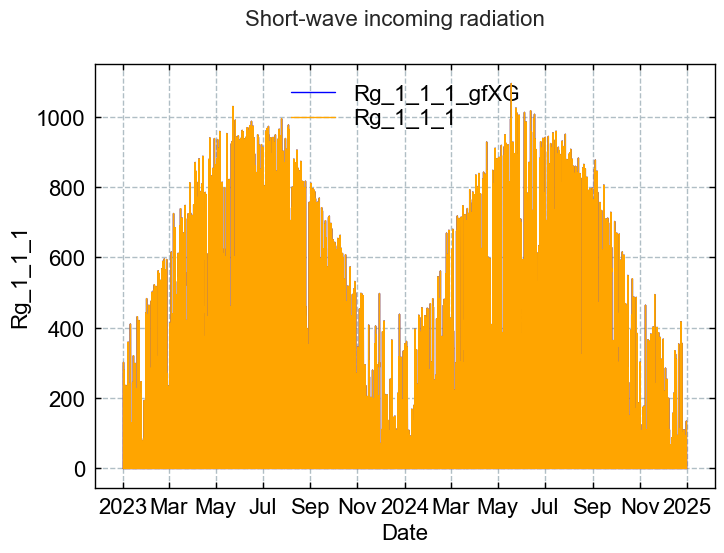

In [15]:
title="Short-wave incoming radiation"
fig, ax = plt.subplots()
TimeSeries(series=gapfilled, ax=ax).plot(color='blue')
TimeSeries(series=observed, ax=ax).plot(color='orange')
fig.suptitle(f'{title}', fontsize=16)
# ax.set_ylim(-2000, 200)
fig.show()

## TA

In [16]:
_df = pd.DataFrame()
_df['Rg_1_1_1_gfXG'] = data_simple_merged['Rg_1_1_1_gfXG'].copy()
_df['Ta_1_1_1'] = data_simple_merged['Ta_1_1_1'].copy()
_df['SW_IN_POT'] = potrad(timestamp_index=_df.index,
                          lat=47.210227,  # CH-CHA
                          lon=8.410645,  # CH-CHA
                          utc_offset=1)
_df

,Rg_1_1_1_gfXG,Ta_1_1_1,SW_IN_POT
TIMESTAMP_END,,,
2023-01-01 00:30:00,0.0,2.898533,0.0
2023-01-01 01:00:00,0.0,2.994261,0.0
2023-01-01 01:30:00,0.0,3.722800,0.0
2023-01-01 02:00:00,0.0,4.535267,0.0
2023-01-01 02:30:00,0.0,3.949122,0.0
...,...,...,...
2024-12-31 22:00:00,0.0,-1.919472,0.0
2024-12-31 22:30:00,0.0,-2.104678,0.0
2024-12-31 23:00:00,0.0,-2.089444,0.0


In [17]:
xgb = XGBoostTS(
    input_df=_df,
    target_col='Ta_1_1_1',
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=200,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 35088.


In [18]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()


Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2023-01-01 01:00:00 and 2025-01-01 00:00:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:6.31660	validation_1-rmse:6.32867
[1]	validation_0-rmse:5.00830	validation_1-rmse:5.03651
[2]	validation_0-rmse:4.16933	validation_1-rmse:4.19922
[3]	validation_0-rmse:3.65232	validation_1-rmse:3.69732
[4]	validation_0-rmse:3.29492	validation_1-rmse:3.34859
[5]	validation_0-rmse:3.06248	validation_1-rmse:3.12606
[6]	validation_0-rmse:2.92051	validation_1-rmse:2.99337
[7]	validation_0-rmse:2.80883	validation_1-rmse:2.89222
[8]	validation_0-rmse:2.72994	validation_1-rmse:2.81899
[9]	validation_0-rmse:2.65627	validation_1-rmse:2.74722
[10]	validation_0-rmse:2.56741	validation_1-rmse:2.66516
[11]	validation_0-rmse:2.52084	validation_1-rmse:2.62707
[12]	validation_0-rmse:2.47237	validation_1-rmse:2.57709
[13]	validation_0-rmse:2.42863	validation_1-rmse:2.53237
[14]	validation_0-r

In [19]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()


Gap-filling using final model ...
>>> Using final model on all data to predict target Ta_1_1_1 ...
>>> Using final model on all data to calculate permutation importance ...
>>> Calculating prediction scores based on all data predicting Ta_1_1_1 ...
>>> Predicting target Ta_1_1_1 where all features are available ... predicted 35088 records.
>>> Collecting results for final model ...
>>> Filling 25 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable Ta_1_1_1_gfXG ...
>>> Restoring original timestamp in results ...
>>> Combining predictions from full model and fallback model ...

GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (25 values, Ta_1_1_1_gfXG where flag=1) in comparison to observed targets (35063 values, Ta_1_1_1).

## TARGET
- first timestamp:  2023-01-01 00:30:00
- last timestamp:  2025-01-01 00:00:00
- potential number of values: 35088 values)
- target col

In [20]:
observed = _df['Ta_1_1_1']
gapfilled = xgb.get_gapfilled_target()
data_simple_merged[gapfilled.name] = gapfilled

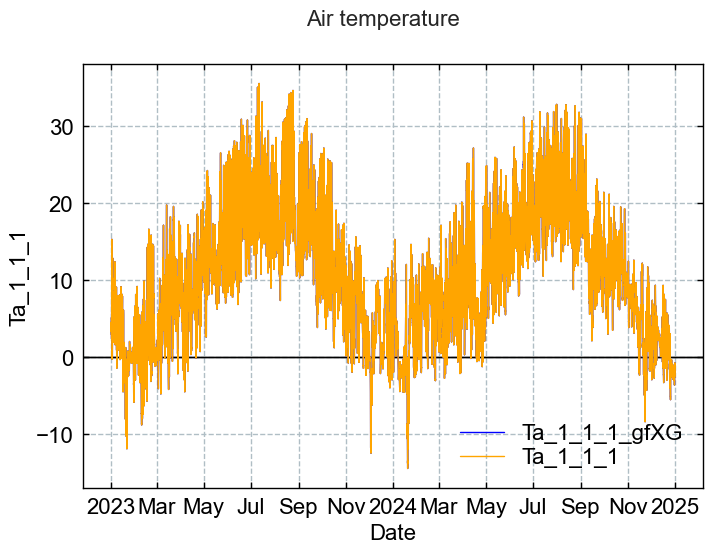

In [21]:
title="Air temperature"
fig, ax = plt.subplots()
TimeSeries(series=gapfilled, ax=ax).plot(color='blue')
TimeSeries(series=observed, ax=ax).plot(color='orange')
fig.suptitle(f'{title}', fontsize=16)
# ax.set_ylim(-2000, 200)
fig.show()

## PPFD

In [22]:
_df = pd.DataFrame()
_df['PPFD_1_1_1'] = data_simple_merged[['PPFD_1_1_1']].copy()
_df['Rg_1_1_1_gfXG'] = data_simple_merged[['Rg_1_1_1_gfXG']].copy()
_df['SW_IN_POT'] = potrad(timestamp_index=_df.index,
                          lat=47.210227,  # CH-CHA
                          lon=8.410645,  # CH-CHA
                          utc_offset=1)
_df

,PPFD_1_1_1,Rg_1_1_1_gfXG,SW_IN_POT
TIMESTAMP_END,,,
2023-01-01 00:30:00,0.0,0.0,0.0
2023-01-01 01:00:00,0.0,0.0,0.0
2023-01-01 01:30:00,0.0,0.0,0.0
2023-01-01 02:00:00,0.0,0.0,0.0
2023-01-01 02:30:00,0.0,0.0,0.0
...,...,...,...
2024-12-31 22:00:00,0.0,0.0,0.0
2024-12-31 22:30:00,0.0,0.0,0.0
2024-12-31 23:00:00,0.0,0.0,0.0


In [23]:
xgb = XGBoostTS(
    input_df=_df,
    target_col='PPFD_1_1_1',
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=200,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 35088.


In [24]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()


Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2023-01-01 01:00:00 and 2025-01-01 00:00:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:315.58993	validation_1-rmse:322.21860
[1]	validation_0-rmse:221.77550	validation_1-rmse:226.34194
[2]	validation_0-rmse:156.11728	validation_1-rmse:159.37323
[3]	validation_0-rmse:110.27418	validation_1-rmse:112.55170
[4]	validation_0-rmse:78.29605	validation_1-rmse:79.87695
[5]	validation_0-rmse:56.08951	validation_1-rmse:57.36709
[6]	validation_0-rmse:40.80334	validation_1-rmse:41.98742
[7]	validation_0-rmse:30.44966	validation_1-rmse:31.61549
[8]	validation_0-rmse:23.51941	validation_1-rmse:24.87387
[9]	validation_0-rmse:18.98309	validation_1-rmse:20.62536
[10]	validation_0-rmse:16.18957	validation_1-rmse:18.12139
[11]	validation_0-rmse:14.42012	validation_1-rmse:16.56105
[12]	validation_0-rmse:13.08758	validation_1-rmse:15.38913
[13]	validation_0-rmse:12.26647	validation

In [25]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()


Gap-filling using final model ...
>>> Using final model on all data to predict target PPFD_1_1_1 ...
>>> Using final model on all data to calculate permutation importance ...
>>> Calculating prediction scores based on all data predicting PPFD_1_1_1 ...
>>> Predicting target PPFD_1_1_1 where all features are available ... predicted 35088 records.
>>> Collecting results for final model ...
>>> Filling 20 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable PPFD_1_1_1_gfXG ...
>>> Restoring original timestamp in results ...
>>> Combining predictions from full model and fallback model ...

GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (20 values, PPFD_1_1_1_gfXG where flag=1) in comparison to observed targets (35068 values, PPFD_1_1_1).

## TARGET
- first timestamp:  2023-01-01 00:30:00
- last timestamp:  2025-01-01 00:00:00
- potential number of values: 35088 values)


In [26]:
observed = _df['PPFD_1_1_1']
gapfilled = xgb.get_gapfilled_target()
data_simple_merged[gapfilled.name] = gapfilled

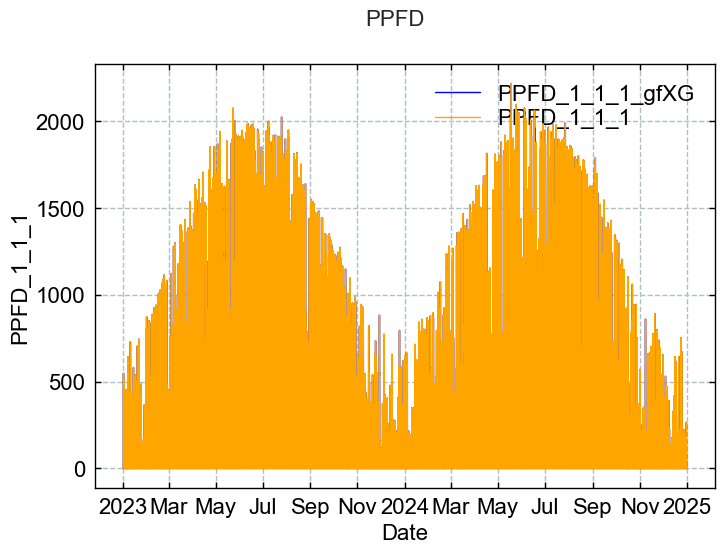

In [27]:
title="PPFD"
fig, ax = plt.subplots()
TimeSeries(series=gapfilled, ax=ax).plot(color='blue')
TimeSeries(series=observed, ax=ax).plot(color='orange')
fig.suptitle(f'{title}', fontsize=16)
# ax.set_ylim(-2000, 200)
fig.show()

</br>

# **Plots**

In [28]:
_plot_df = data_simple_merged[['Lwin_1_1_1', 'PPFD_1_1_1', 'PPFD_1_1_1_gfXG', 'RH_1_1_1', 'Rg_1_1_1', 'Rg_1_1_1_gfXG', 'Ta_1_1_1', 'Ta_1_1_1_gfXG', 'Pa_1_1_1']].copy()
_plot_df = _plot_df.replace(-9999, np.nan)

## Time series plot

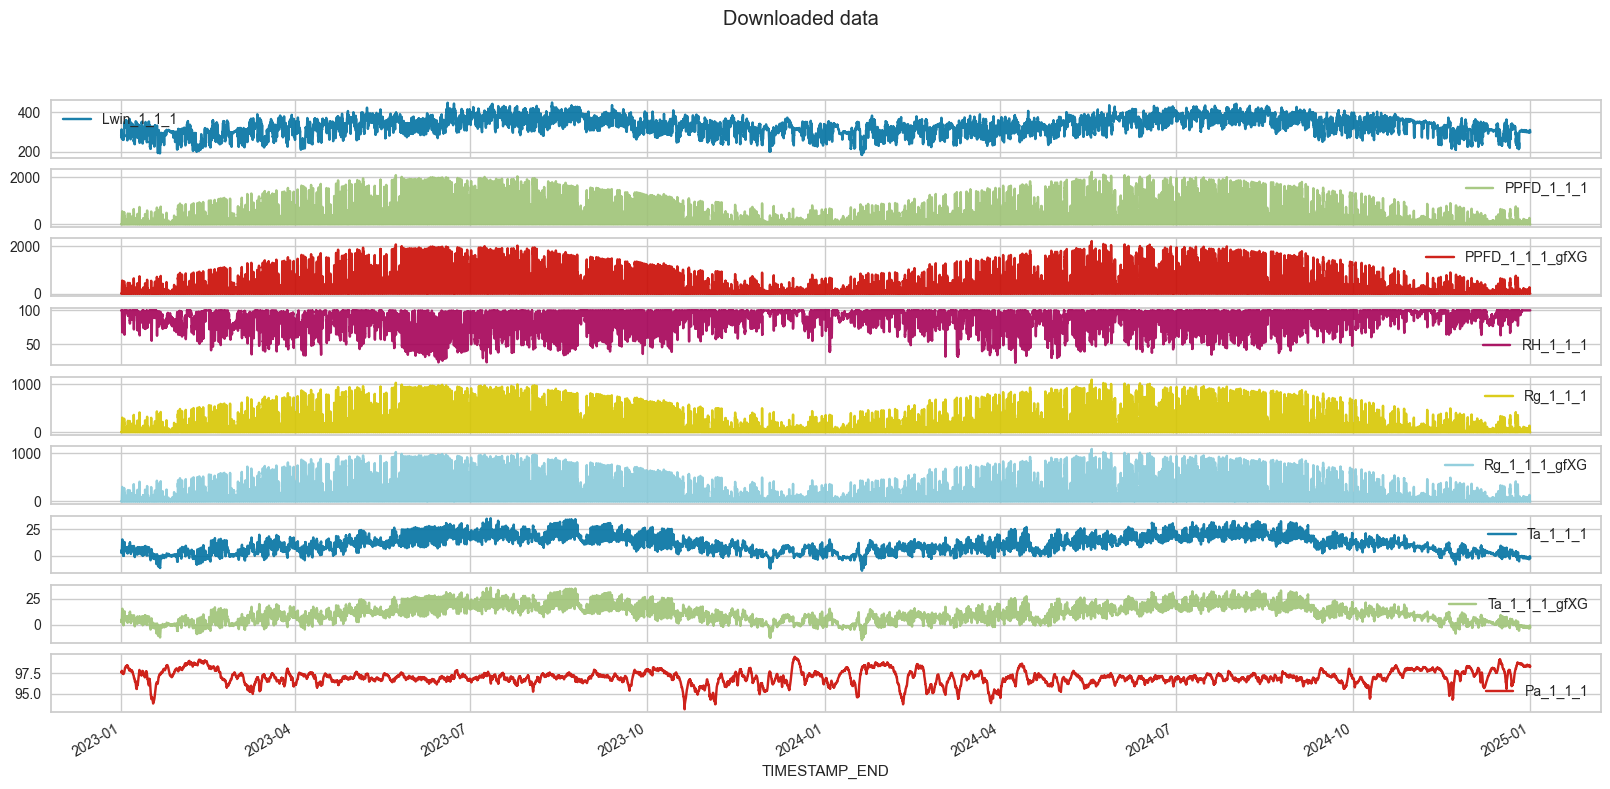

In [29]:
_plot_df.plot(subplots=True, figsize=(20, 9), title="Downloaded data", alpha=.9, x_compat=True);

## Heatmaps

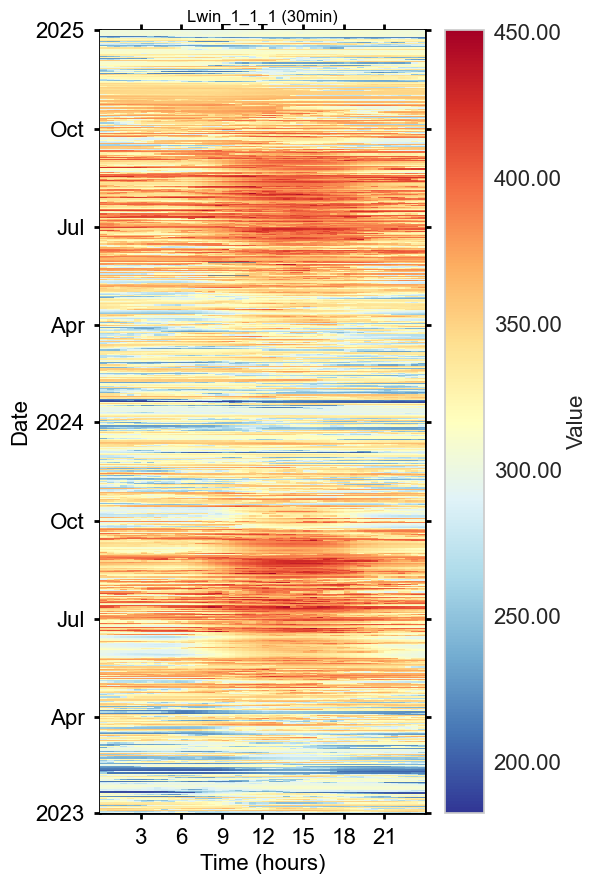

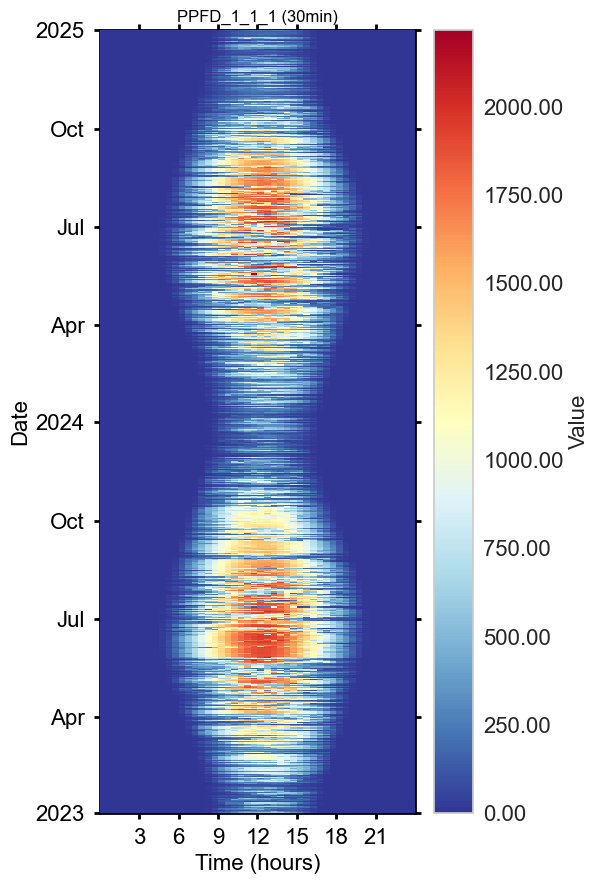

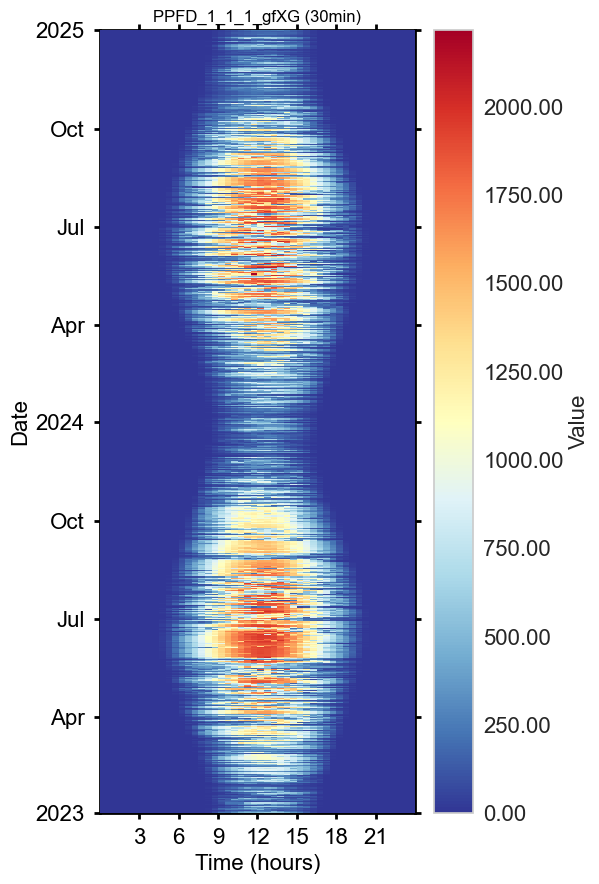

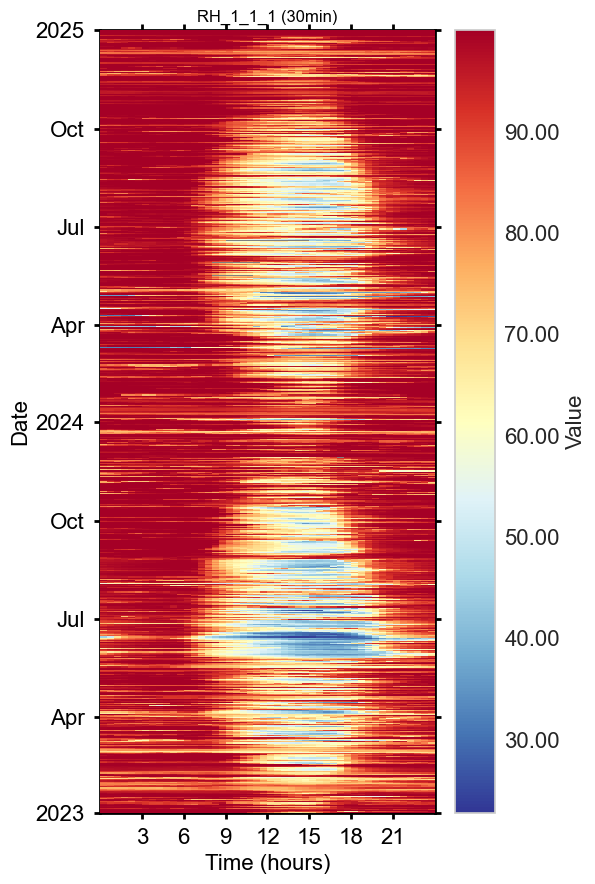

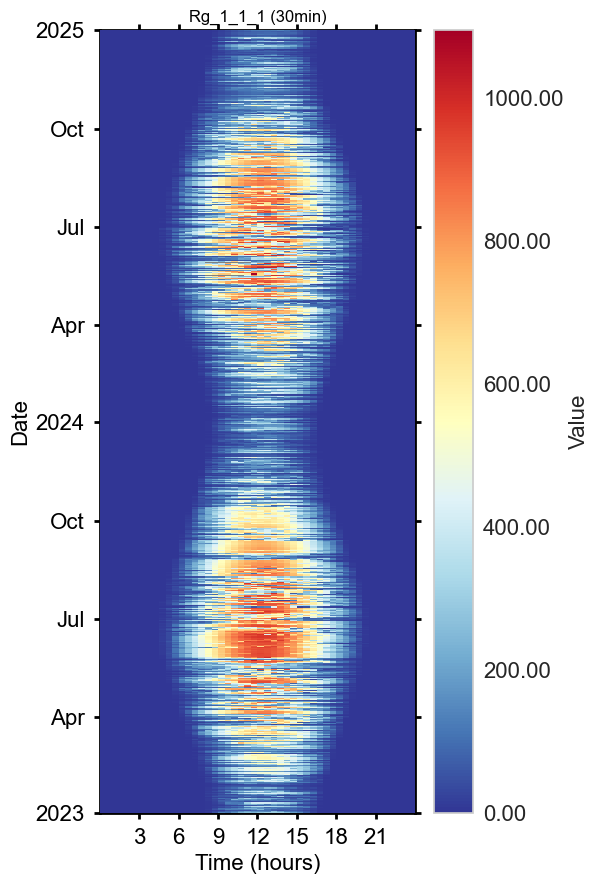

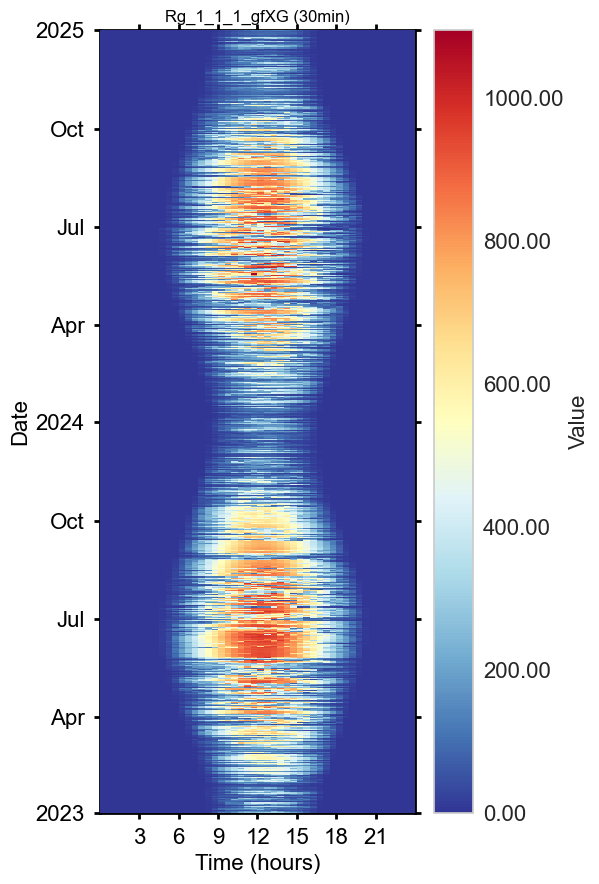

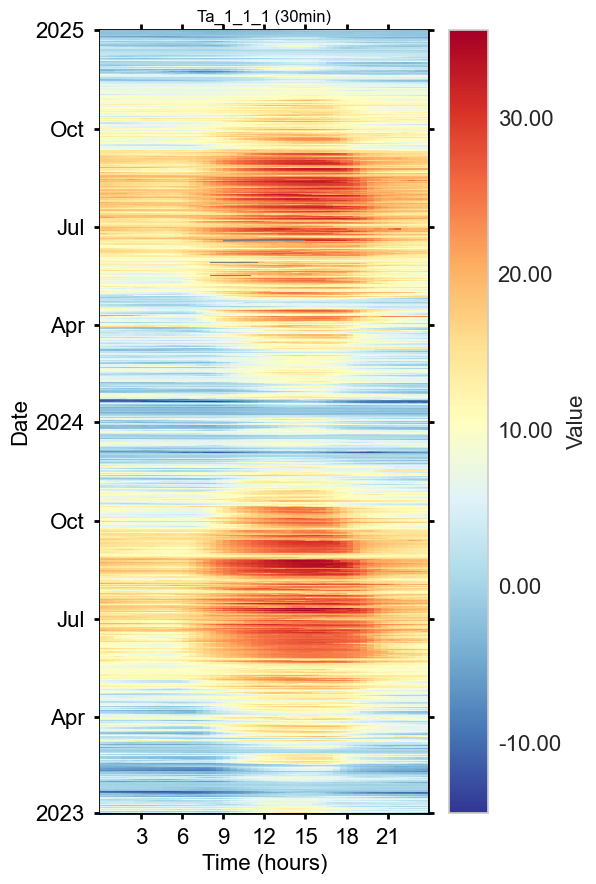

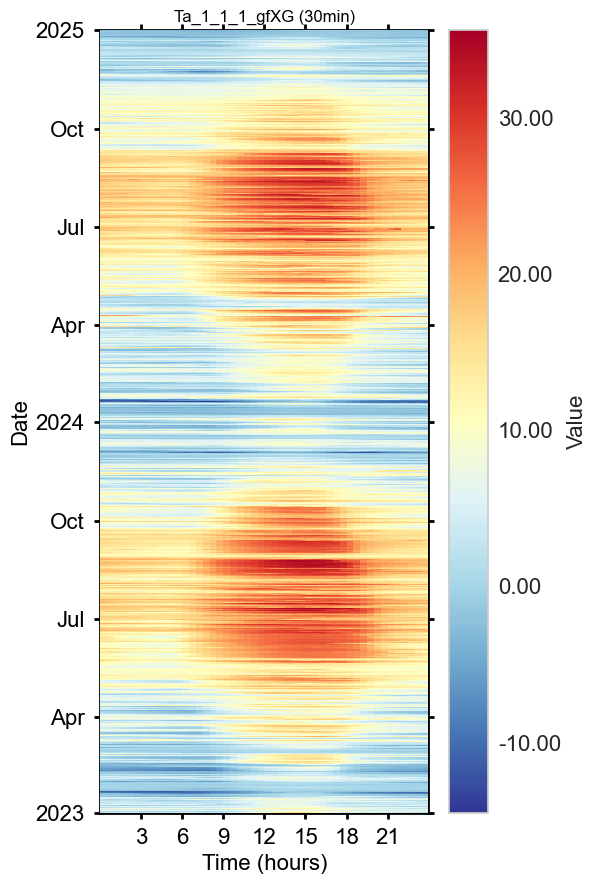

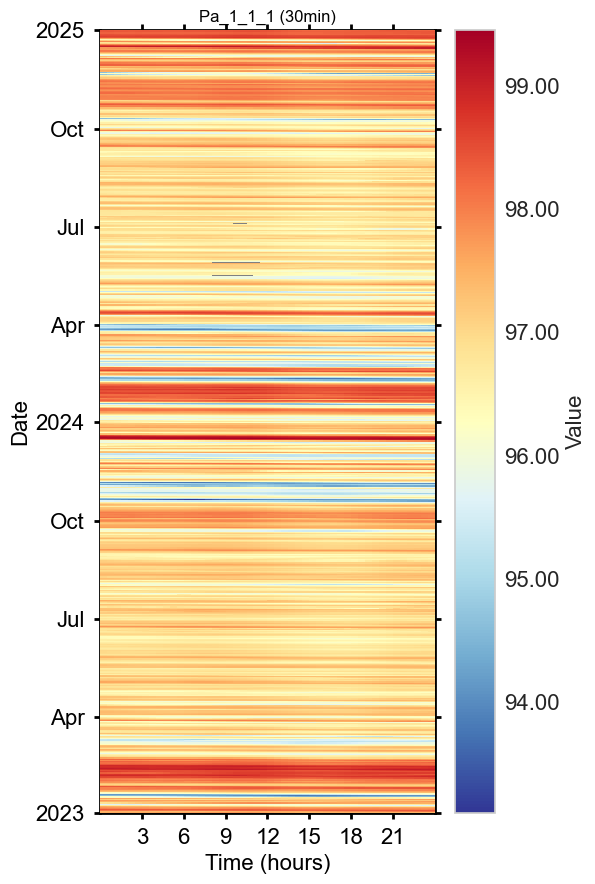

In [30]:
for col in _plot_df.columns:    
    series = _plot_df[col]
    series.name = col
    HeatmapDateTime(series, figsize=(6,9)).show()    

</br>

# **Stats**

In [31]:
data_simple_merged.describe()

,Lwin_1_1_1,Pa_1_1_1,PPFD_1_1_1,RH_1_1_1,Rg_1_1_1,Ta_1_1_1,Rg_1_1_1_gfXG,Ta_1_1_1_gfXG,PPFD_1_1_1_gfXG
count,35075.000000,35073.000000,35068.000000,35062.000000,35075.000000,35063.000000,35088.000000,35088.000000,35088.000000
mean,332.137387,96.956027,271.255089,86.281232,138.488219,10.679537,138.572044,10.685542,271.717489
std,44.123657,0.829462,452.059234,16.308688,228.228201,8.258777,228.246029,8.259957,452.525111
min,182.633747,93.096466,0.000000,22.759181,0.000000,-14.506039,0.000000,-14.506039,0.000000
25%,304.855622,96.534512,0.000000,77.638477,0.000000,4.457578,0.000000,4.460789,0.000000
50%,335.314280,96.958003,5.542730,93.412062,3.466539,10.068922,3.504461,10.078019,5.647952
75%,363.469465,97.398187,358.482608,99.525425,186.051424,16.355511,186.508667,16.367913,360.055728
max,450.673410,99.452946,2215.730247,99.997990,1094.550105,35.581697,1094.550105,35.581697,2215.730247


</br>

# **Keep relevant columns**

In [32]:
data_simple_merged.columns

Index(['Lwin_1_1_1', 'Pa_1_1_1', 'PPFD_1_1_1', 'RH_1_1_1', 'Rg_1_1_1', 'Ta_1_1_1', 'Rg_1_1_1_gfXG', 'Ta_1_1_1_gfXG', 'PPFD_1_1_1_gfXG'], dtype='object')

In [33]:
keepcols = ['Lwin_1_1_1', 'RH_1_1_1', 'Pa_1_1_1', 'Rg_1_1_1_gfXG', 'Ta_1_1_1_gfXG', 'PPFD_1_1_1_gfXG']
data_simple_merged = data_simple_merged[keepcols].copy()
data_simple_merged

,Lwin_1_1_1,RH_1_1_1,Pa_1_1_1,Rg_1_1_1_gfXG,Ta_1_1_1_gfXG,PPFD_1_1_1_gfXG
TIMESTAMP_END,,,,,,
2023-01-01 00:30:00,281.242257,99.902748,97.562395,0.0,2.898533,0.0
2023-01-01 01:00:00,284.605240,99.902748,97.572526,0.0,2.994261,0.0
2023-01-01 01:30:00,290.366950,99.902748,97.596154,0.0,3.722800,0.0
2023-01-01 02:00:00,299.299250,99.902748,97.594182,0.0,4.535267,0.0
2023-01-01 02:30:00,294.512940,99.902748,97.579468,0.0,3.949122,0.0
...,...,...,...,...,...,...
2024-12-31 22:00:00,304.613900,99.997990,98.337089,0.0,-1.919472,0.0
2024-12-31 22:30:00,303.039890,99.997990,98.305216,0.0,-2.104678,0.0
2024-12-31 23:00:00,302.093633,99.997990,98.285114,0.0,-2.089444,0.0


</br>

# **Add timestamp columns for EddyPro**

In [34]:
# EddyPro needs two columns: date and time
data_simple_merged['date'] = data_simple_merged.index.date
data_simple_merged['date'] = data_simple_merged['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

data_simple_merged['time'] = data_simple_merged.index.time
data_simple_merged['time'] = data_simple_merged['time'].apply(lambda x: x.strftime('%H:%M'))

# Move date and time columns to start of dataframe
col = data_simple_merged.pop('date')
data_simple_merged.insert(0, col.name, col)
col = data_simple_merged.pop('time')
data_simple_merged.insert(1, col.name, col)

data_simple_merged

,date,time,Lwin_1_1_1,RH_1_1_1,Pa_1_1_1,Rg_1_1_1_gfXG,Ta_1_1_1_gfXG,PPFD_1_1_1_gfXG
TIMESTAMP_END,,,,,,,,
2023-01-01 00:30:00,2023-01-01,00:30,281.242257,99.902748,97.562395,0.0,2.898533,0.0
2023-01-01 01:00:00,2023-01-01,01:00,284.605240,99.902748,97.572526,0.0,2.994261,0.0
2023-01-01 01:30:00,2023-01-01,01:30,290.366950,99.902748,97.596154,0.0,3.722800,0.0
2023-01-01 02:00:00,2023-01-01,02:00,299.299250,99.902748,97.594182,0.0,4.535267,0.0
2023-01-01 02:30:00,2023-01-01,02:30,294.512940,99.902748,97.579468,0.0,3.949122,0.0
...,...,...,...,...,...,...,...,...
2024-12-31 22:00:00,2024-12-31,22:00,304.613900,99.997990,98.337089,0.0,-1.919472,0.0
2024-12-31 22:30:00,2024-12-31,22:30,303.039890,99.997990,98.305216,0.0,-2.104678,0.0
2024-12-31 23:00:00,2024-12-31,23:00,302.093633,99.997990,98.285114,0.0,-2.089444,0.0


</br>

# **Add units for EddyPro input file**

In [35]:
renaming_dict = {
    'date': ('date', 'yyyy-mm-dd'),
    'time': ('time', 'HH:MM'),
    'Lwin_1_1_1': ('Lwin_1_1_1', 'W+1m-2'),
    'PPFD_1_1_1_gfXG': ('PPFD_1_1_1', 'umol+1m-2s-1'),
    'RH_1_1_1': ('RH_1_1_1', '%'),
    'Rg_1_1_1_gfXG': ('Rg_1_1_1', 'W+1m-2'),
    'Ta_1_1_1_gfXG': ('Ta_1_1_1', 'C'),
    'Pa_1_1_1': ('Pa_1_1_1', 'kPa')
}
data_simple_merged = data_simple_merged.rename(columns=renaming_dict)
data_simple_merged.columns = pd.MultiIndex.from_tuples(data_simple_merged.columns)
data_simple_merged

,date,time,Lwin_1_1_1,RH_1_1_1,Pa_1_1_1,Rg_1_1_1,Ta_1_1_1,PPFD_1_1_1
,yyyy-mm-dd,HH:MM,W+1m-2,%,kPa,W+1m-2,C,umol+1m-2s-1
TIMESTAMP_END,,,,,,,,
2023-01-01 00:30:00,2023-01-01,00:30,281.242257,99.902748,97.562395,0.0,2.898533,0.0
2023-01-01 01:00:00,2023-01-01,01:00,284.605240,99.902748,97.572526,0.0,2.994261,0.0
2023-01-01 01:30:00,2023-01-01,01:30,290.366950,99.902748,97.596154,0.0,3.722800,0.0
2023-01-01 02:00:00,2023-01-01,02:00,299.299250,99.902748,97.594182,0.0,4.535267,0.0
2023-01-01 02:30:00,2023-01-01,02:30,294.512940,99.902748,97.579468,0.0,3.949122,0.0
...,...,...,...,...,...,...,...,...
2024-12-31 22:00:00,2024-12-31,22:00,304.613900,99.997990,98.337089,0.0,-1.919472,0.0
2024-12-31 22:30:00,2024-12-31,22:30,303.039890,99.997990,98.305216,0.0,-2.104678,0.0


</br>

# **Set missing values code** to -9999

In [36]:
# EddyPro needs missing values as -9999
data_simple_merged = data_simple_merged.fillna(-9999)
data_simple_merged

,date,time,Lwin_1_1_1,RH_1_1_1,Pa_1_1_1,Rg_1_1_1,Ta_1_1_1,PPFD_1_1_1
,yyyy-mm-dd,HH:MM,W+1m-2,%,kPa,W+1m-2,C,umol+1m-2s-1
TIMESTAMP_END,,,,,,,,
2023-01-01 00:30:00,2023-01-01,00:30,281.242257,99.902748,97.562395,0.0,2.898533,0.0
2023-01-01 01:00:00,2023-01-01,01:00,284.605240,99.902748,97.572526,0.0,2.994261,0.0
2023-01-01 01:30:00,2023-01-01,01:30,290.366950,99.902748,97.596154,0.0,3.722800,0.0
2023-01-01 02:00:00,2023-01-01,02:00,299.299250,99.902748,97.594182,0.0,4.535267,0.0
2023-01-01 02:30:00,2023-01-01,02:30,294.512940,99.902748,97.579468,0.0,3.949122,0.0
...,...,...,...,...,...,...,...,...
2024-12-31 22:00:00,2024-12-31,22:00,304.613900,99.997990,98.337089,0.0,-1.919472,0.0
2024-12-31 22:30:00,2024-12-31,22:30,303.039890,99.997990,98.305216,0.0,-2.104678,0.0


</br>

# **Save to file**

In [37]:
data_simple_merged.to_csv(OUTFILE, index=False)

</br>

# **End of notebook**.

In [38]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2025-01-20 15:21:24


</br>

# (Bonus)

In [39]:
# ta = data_simple_merged[('Ta_1_1_1', 'C')].copy()
# ta = TimestampSanitizer(data=ta).get()
# ta = ta.loc[ta.index.year > 2005].copy()
# means = ta.groupby(ta.index.year).mean()
# means

In [40]:
# means.sort_values(ascending=False).head(5)

In [41]:
# means.loc[means.index > 2014].mean()